 Prepare the general libraries.

In [1]:
# libraries
library(community)
library(ggplot2)

 Prepare the path.

In [2]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- 'computed_results/'

print("path_in")
print(path_in)

[1] "path_in"
[1] "computed_results/"


Load data.

In [3]:
suppressWarnings(load(paste0(path_in,"/interactions.RData")))

Load functions for visualization.

In [4]:
data("visualization_functions")

## Parameters

In [5]:
# threshold for log2FC of the weights
threshold_log2FC <- interactions$thresholds$threshold_log2FC

idx_up <- interactions$anno_interactions$log2FC_weights > threshold_log2FC
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<= threshold_log2FC
idx_down <- interactions$anno_interactions$log2FC_weights < -threshold_log2FC
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [6]:
# extract cell types
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Mono" "Gran" "T"    "NK"   "B"    "HSPC" "Ery"  "DC"  


In [23]:
# define broad type of interactions by cell types
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]

interaction_cell_types <- unique(paste(interactions$anno_interactions$sending_cell_type
                                ,interactions$anno_interactions$receiving_cell_type
                                ,sep = " to "))

interaction_type <- sapply(interaction_cell_types
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type))

interaction_type_by_ID <- sapply(interactions$anno_interactions$interaction_ID
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type_by_ID))

colors_interaction_type <- c("engages HSPC" = "magenta"
                             ,"among immune cells" = "deepskyblue"
                             ,"engages Ery" = "darkgoldenrod3"#"lightgoldenrod"
                            )
print(colors_interaction_type)

 Named chr [1:64] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:64] "Mono to Mono" "Mono to Gran" "Mono to T" "Mono to NK" ...
NULL
 Named chr [1:151744] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:151744] "Mono:A2M_Mono:LRP1" "Mono:ACTR2_Mono:ADRB2" "Mono:ACTR2_Mono:LDLR" "Mono:ADM_Mono:ACKR3" ...
NULL
      engages HSPC among immune cells        engages Ery 
         "magenta"      "deepskyblue"   "darkgoldenrod3" 


## Visualization: all good quality interactions

### Mean weight vs mean number 

In [8]:
library(ggrepel) # to add text labels on the mean weigth vs number of interactions plot

In [9]:
# claclulate mean weight of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
mean_weights_goodInteractions <- mean_weights(interactions)

print(str(mean_weights_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.04324 0.04169 0.01213 0.00967 0.00597 ...
  ..$ Gran: num [1:8] 0.0407 0.05547 0.01302 0.00914 0.0186 ...
  ..$ T   : num [1:8] 0.0113 0.0166 0.0923 0.078 0.0237 ...
  ..$ NK  : num [1:8] 0.00926 0.0116 0.07798 0.07479 0.01584 ...
  ..$ B   : num [1:8] 0.00493 0.01884 0.02198 0.01491 0.01931 ...
  ..$ HSPC: num [1:8] 0.0114 0.0284 0.0286 0.0185 0.0248 ...
  ..$ Ery : num [1:8] 0.00124 0.00595 0.00821 0.00289 0.00763 ...
  ..$ DC  : num [1:8] 0.01256 0.01904 0.02985 0.02701 0.00711 ...
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.0296 0.0468 0.0234 0.0209 0.0269 ...
  ..$ Gran: num [1:8] 0.0429 0.0785 0.0339 0.0268 0.0425 ...
  ..$ T   : num [1:8] 0.0256 0.0385 0.0353 0.0234 0.0344 ...
  ..$ NK  : num [1:8] 0.0219 0.0282 0.0226 0.0187 0.0198 ...
  ..$ B   : num [1:8] 0.0278 0.0476 0.0318 0.0183 0.0544 ...
  ..$ HSPC: num [1:8] 0.00699 0.01194 0.00572 0.00466 0.0067 ...
  ..$ Er

In [10]:
# claclulate number of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
number_goodInteractions <- number_interactions(interactions)

print(str(number_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 839 619 582 413 449 531 221 558
  ..$ Gran: int [1:8] 632 472 457 314 362 415 288 437
  ..$ T   : int [1:8] 593 444 498 348 389 425 280 454
  ..$ NK  : int [1:8] 370 281 294 224 225 256 111 283
  ..$ B   : int [1:8] 350 276 294 194 225 257 172 266
  ..$ HSPC: int [1:8] 489 362 406 260 312 412 244 325
  ..$ Ery : int [1:8] 175 218 230 96 199 225 175 142
  ..$ DC  : int [1:8] 554 405 421 296 314 347 154 417
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 840 620 602 424 473 532 228 604
  ..$ Gran: int [1:8] 638 478 470 333 370 420 295 476
  ..$ T   : int [1:8] 616 455 498 348 393 426 280 477
  ..$ NK  : int [1:8] 377 290 294 224 228 258 113 296
  ..$ B   : int [1:8] 359 281 295 199 225 255 172 283
  ..$ HSPC: int [1:8] 481 367 400 264 304 388 244 353
  ..$ Ery : int [1:8] 187 230 231 96 199 225 175 200
  ..$ DC  : int [1:8] 623 468 449 321 350 383 208 468
NULL


In [11]:
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]
grepl(paste(immune_cell_types, collapse="|"), "B cell")

[1] TRUE

'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.04324 0.04169 0.01213 0.00967 0.00597 ...
 $ number_of_interactions : int  839 619 582 413 449 531 221 558 632 472 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL
'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.0296 0.0468 0.0234 0.0209 0.0269 ...
 $ number_of_interactions : int  840 620 602 424 473 532 228 604 638 478 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL


Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 53 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 59 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[[1]]

[[2]]


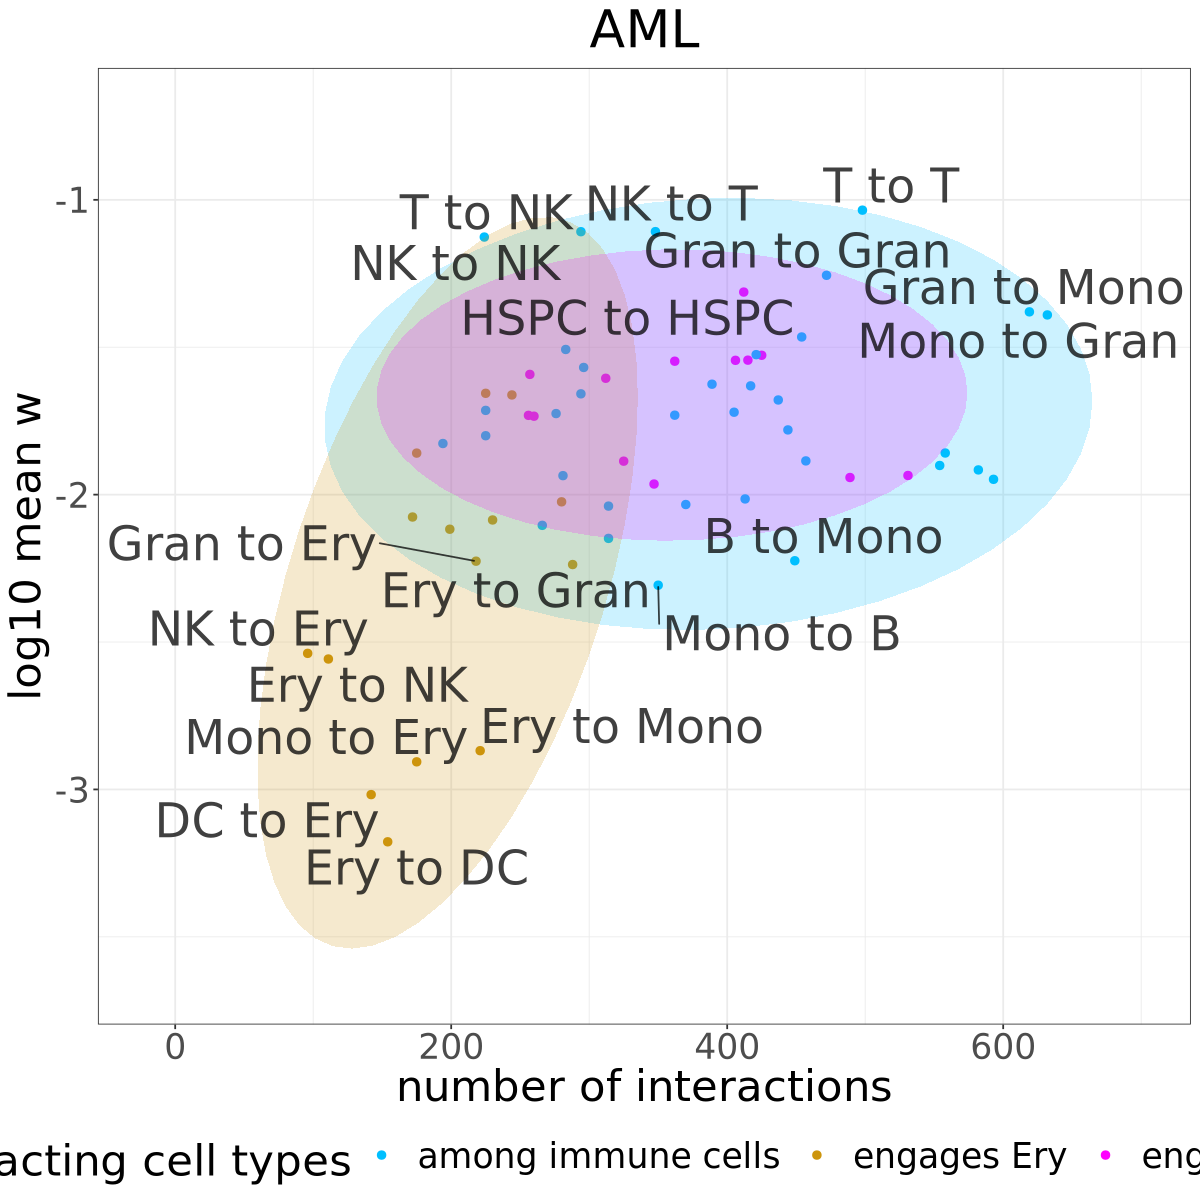

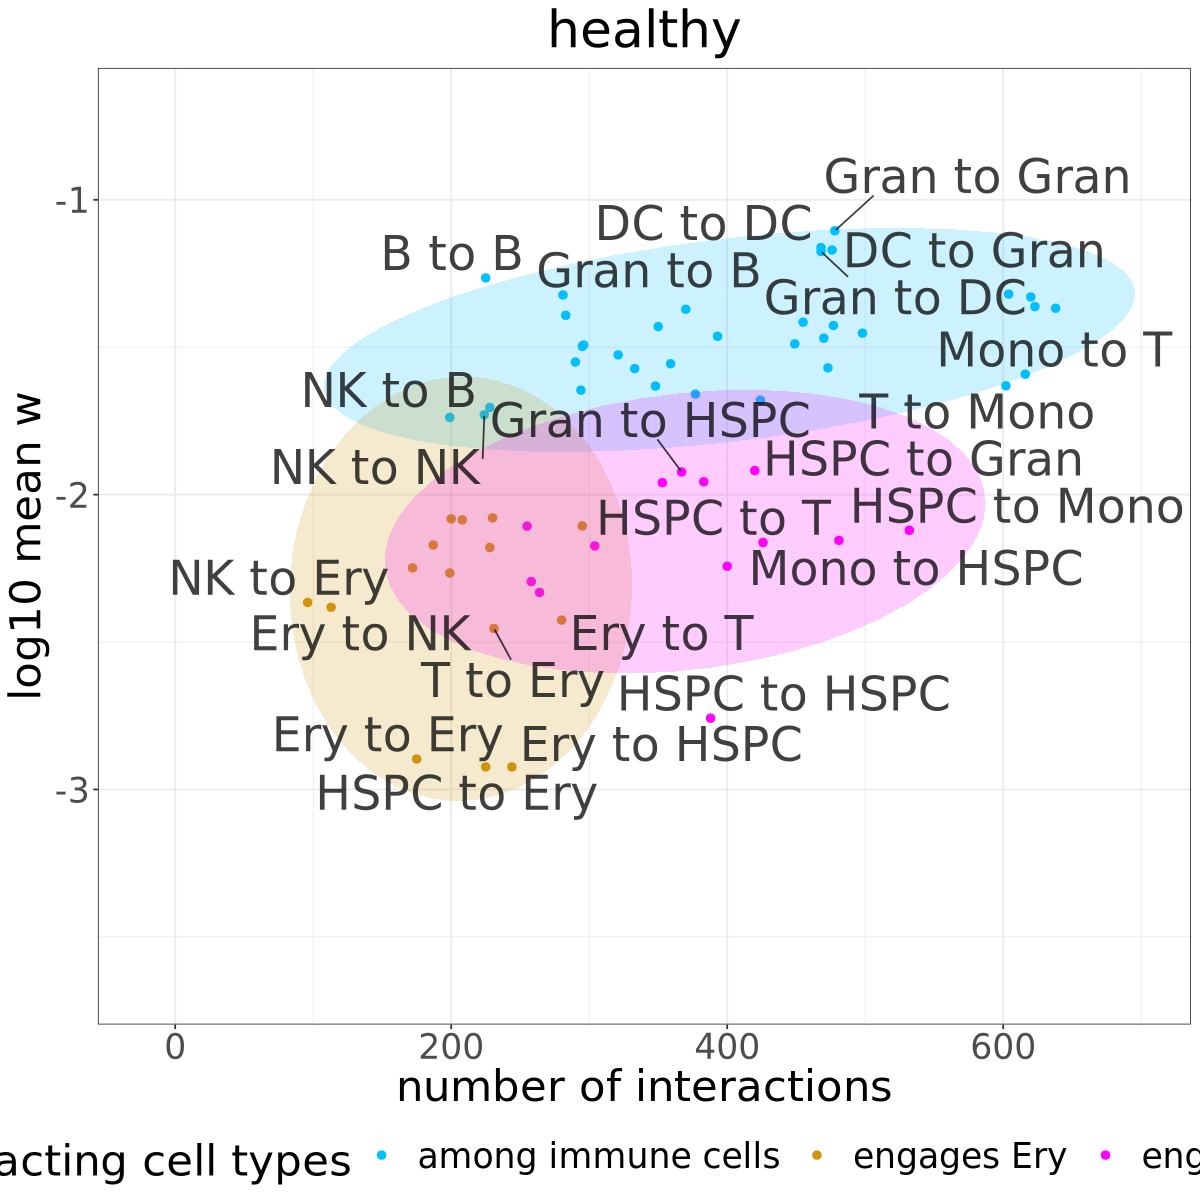

In [24]:
# plot mumber of interactions vs mean interaction weights per cell type to cell type interaction
options(repr.plot.width = 10
        ,repr.plot.height = 10)

ylim <- c(-3.65, -0.7)
xlim <- c(-20, 700)

plot_nrInt_vs_meanW_perCellType(interactions
                               ,interaction_type = interaction_type
                               ,colors = colors_interaction_type
                               ,ylim = ylim
                               ,label_font_size = 10)

### Ligand-receptor families

## Visualization of differential interactions

### Voclano

In [13]:
print("downregulated:")
print(sum(idx_down & idx_sign))

print("upregulated:")
print(sum(idx_up & idx_sign))

[1] "downregulated:"
[1] 2670
[1] "upregulated:"
[1] 109


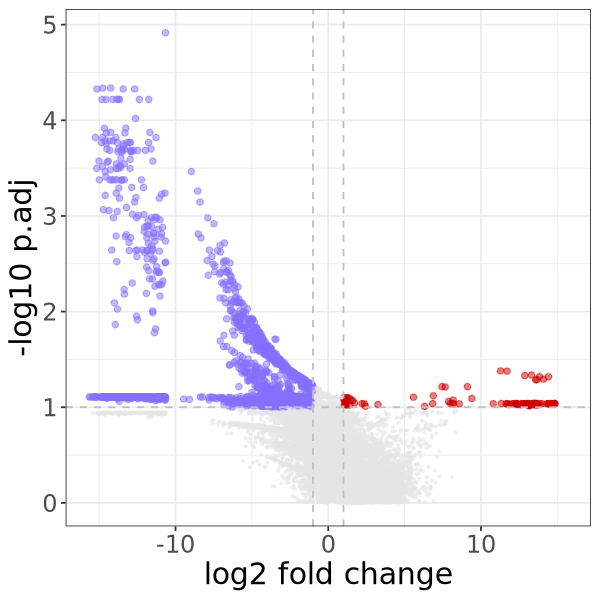

In [14]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 5)
    
plot_vulcano(interactions)

### Heatmap top differential

In [15]:
library(ComplexHeatmap) # to plot heatmaps
library(circlize) # for gragient colors

Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

In [16]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:300]
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:10]

# all upregulated interactions
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign
idx_topup <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topup][1:9]

idx <- idx_topup | idx_topdown

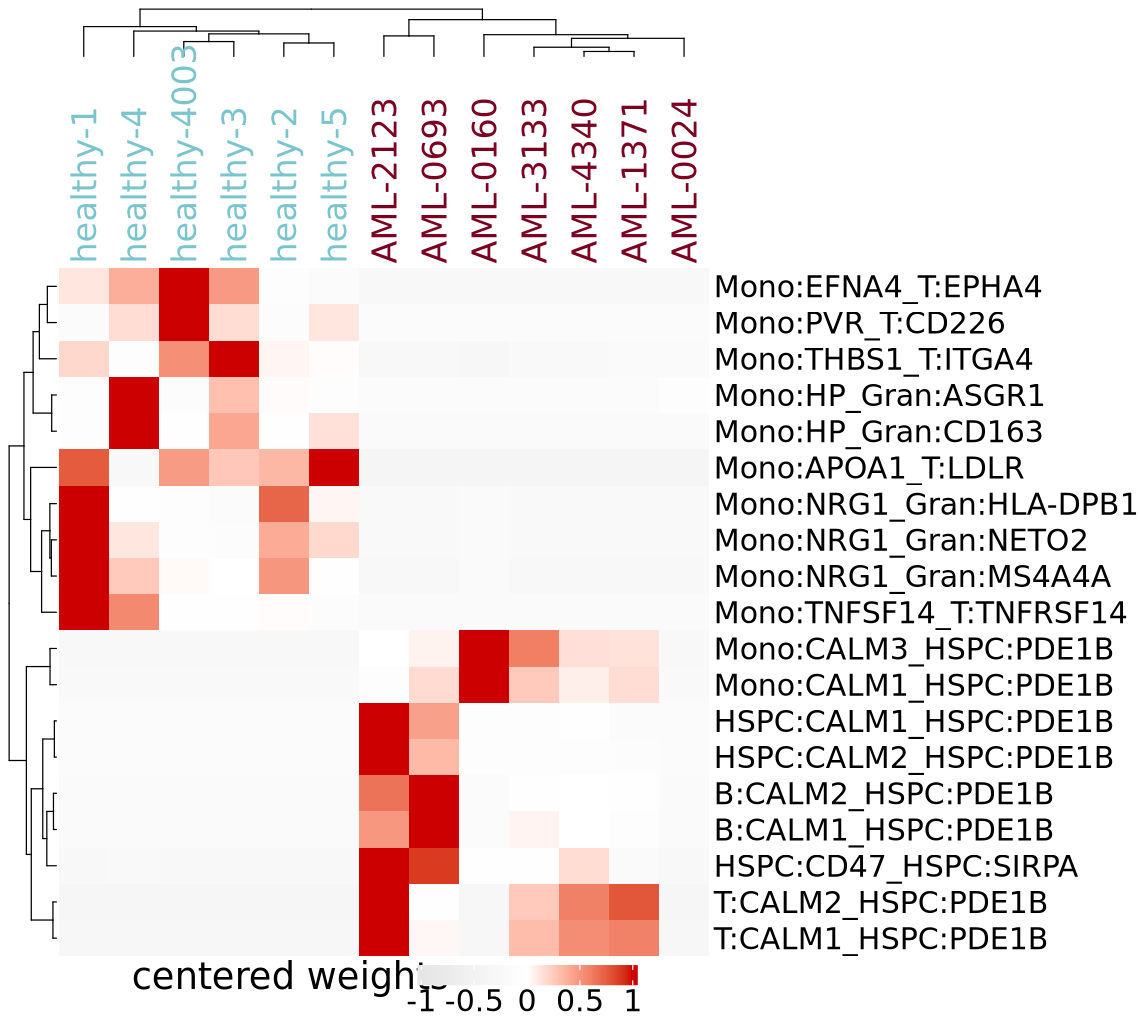

In [17]:
# centred Heatmap
set.seed(3)
options(repr.plot.height = 8.5
       ,repr.plot.width = 9.5
       )
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights"
            ,row_font_size =18
            ,column_font_size = 20
             ,centered = TRUE
             ,color_values = circlize::colorRamp2(c(-1,0,1), c("gray90","white", "red3"))
             ,legend_title_font_size = 22
             ,labels_font_size = 18
            )

### Network plots

In [18]:
library(igraph) # to plot circus plots


Attaching package: ‘igraph’


The following object is masked from ‘package:circlize’:

    degree


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




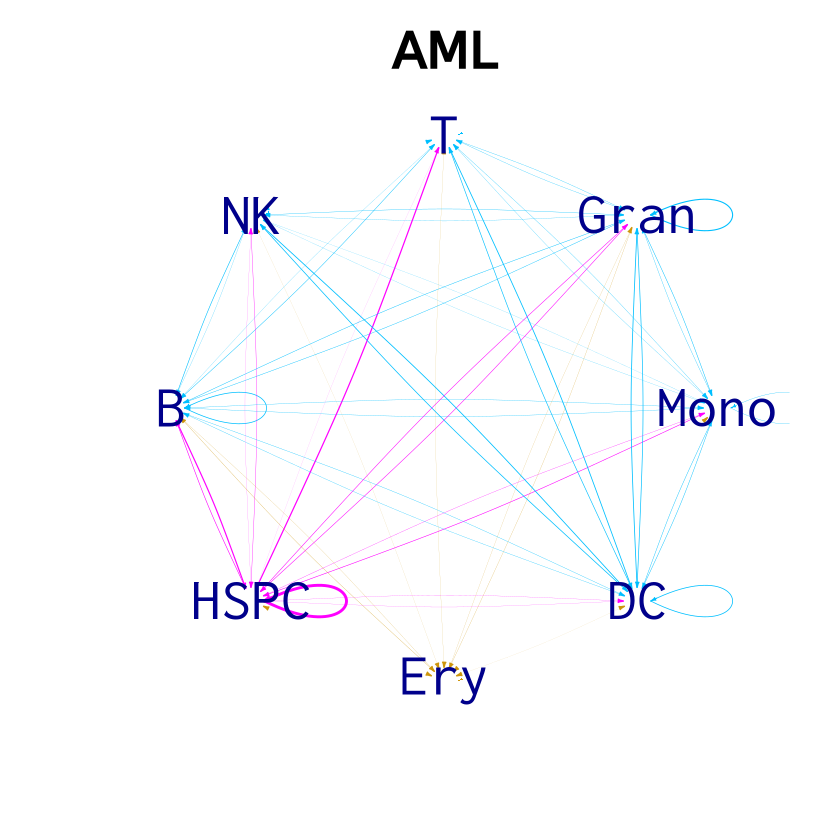

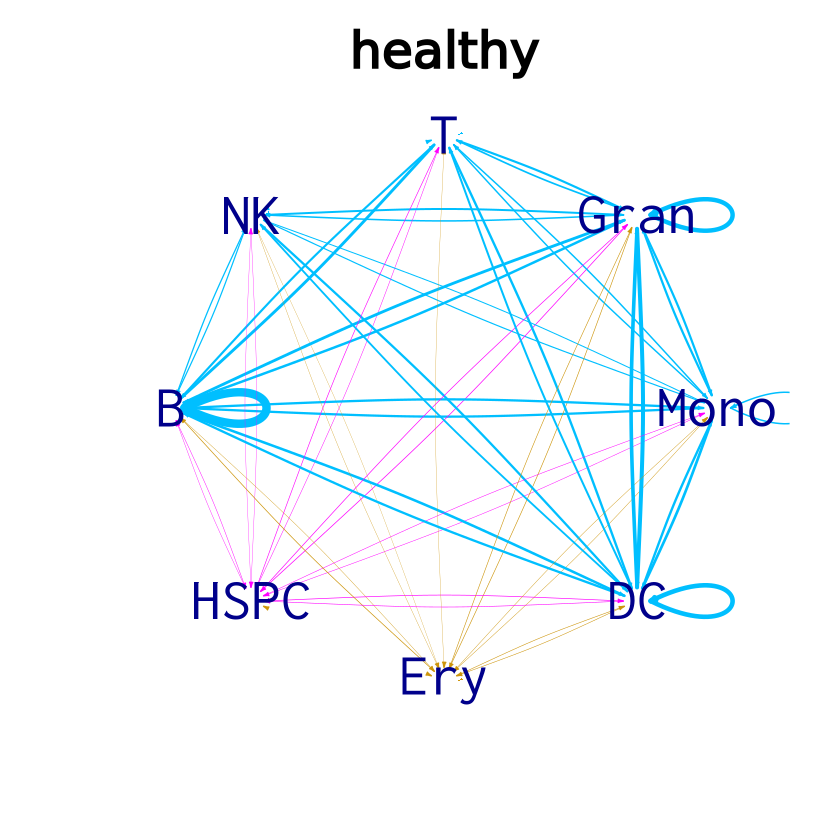

In [25]:
options(repr.plot.width = 7
       ,repr.plot.height = 7)

colors <- colors_interaction_type[interaction_type]
names(colors) <- names(interaction_type)

plor_celltype_network(interactions
                     ,edge.color = colors
                     ,title_cex = 2.5
                     ,vertex.label.cex = 3
                     ,edge.arrow.size = 0.2
                     ,verbose = FALSE
                     )

## Visualization of individual components

<img src="components_scheme.png">

### Forest plots

In [24]:
library(gridExtra) 

In [25]:
# indices

idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

idx_up <- interactions$anno_interactions$log2FC_weights >1
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
idx_down <- interactions$anno_interactions$log2FC_weights < -1

idx_only_rho_s <- interactions$anno_interactions$components_affected_s == "rho" & interactions$anno_interactions$nr_comp_affected_b == 1 
idx_only_rho_r <- interactions$anno_interactions$components_affected_r == "rho" & interactions$anno_interactions$nr_comp_affected_b == 1 
idx_only_phi_s <- interactions$anno_interactions$components_affected_s == "phi" & interactions$anno_interactions$nr_comp_affected_b == 1 
idx_only_phi_r <- interactions$anno_interactions$components_affected_r == "phi" & interactions$anno_interactions$nr_comp_affected_b == 1 
idx_only_p_s <- interactions$anno_interactions$components_affected_s == "p" & interactions$anno_interactions$nr_comp_affected_b == 1 
idx_only_p_r <- interactions$anno_interactions$components_affected_r == "p" & interactions$anno_interactions$nr_comp_affected_b == 1 

idx_nrComp_s_none <- interactions$anno_interactions$nr_comp_affected_s == 0
idx_nrComp_s_one <- interactions$anno_interactions$nr_comp_affected_s == 1
idx_nrComp_s_several <- interactions$anno_interactions$nr_comp_affected_s >1

idx_nrComp_r_none <- interactions$anno_interactions$nr_comp_affected_r == 0
idx_nrComp_r_one <- interactions$anno_interactions$nr_comp_affected_r == 1
idx_nrComp_r_several <- interactions$anno_interactions$nr_comp_affected_r >1

idx_no_change <- interactions$anno_interactions$interaction_category == "no_change"
idx_simple_decrease <- interactions$anno_interactions$interaction_category == "simple_decrease"
idx_simple_increase <- interactions$anno_interactions$interaction_category == "simple_increase"
idx_concordant_decrease <- interactions$anno_interactions$interaction_category == "concordant_decrease"
idx_concordant_increase <- interactions$anno_interactions$interaction_category == "concordant_increase"
idx_insufficient_comp <- interactions$anno_interactions$interaction_category == "insufficient_compensation"
idx_sufficient_comp <- interactions$anno_interactions$interaction_category == "sufficient_compensation"

In [26]:
# ordered IDs

# no change
ID_order_no_change <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                     idx_good &
                                                                                     idx_no_change
                                                                                   ,]
                                                   )$interaction_ID

# simpe down: rho_s -> phi_s -> p_s -> rho_r -> phi_r -> p_r
ID_order_rho_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_decrease &
                                                                                     idx_only_rho_s 
                                                                                    ,]
                                                   )$interaction_ID

ID_order_phi_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_decrease &
                                                                                     idx_only_phi_s 
                                                                                    ,]
                                                   )$interaction_ID

ID_order_p_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_simple_decrease &
                                                                                   idx_only_p_s 
                                                                                   ,]
                                                   )$interaction_ID

ID_order_rho_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_decrease &
                                                                                     idx_only_rho_r
                                                                                    ,]
                                                   )$interaction_ID

ID_order_phi_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_decrease &
                                                                                     idx_only_phi_r
                                                                                    ,]
                                                   )$interaction_ID

ID_order_p_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_simple_decrease &
                                                                                   idx_only_p_r 
                                                                                   ,]
                                                   )$interaction_ID

# simpe up: rho_s -> phi_s -> p_s -> rho_r -> phi_r -> p_r
ID_order_rho_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_increase &
                                                                                     idx_only_rho_s 
                                                                                    ,]
                                                   )$interaction_ID

ID_order_phi_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_increase &
                                                                                     idx_only_phi_s 
                                                                                    ,]
                                                   )$interaction_ID

ID_order_p_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_simple_increase &
                                                                                   idx_only_p_s 
                                                                                   ,]
                                                   )$interaction_ID

ID_order_rho_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_increase &
                                                                                     idx_only_rho_r
                                                                                    ,]
                                                   )$interaction_ID

ID_order_phi_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                     idx_simple_increase &
                                                                                     idx_only_phi_r
                                                                                    ,]
                                                   )$interaction_ID

ID_order_p_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_simple_increase &
                                                                                   idx_only_p_r 
                                                                                   ,]
                                                   )$interaction_ID

# concordant down: sender -> receiver -> both
ID_order_concordantDown_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantDown_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_r_several &
                                                                                   idx_nrComp_s_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantDown_b_one_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_s_one &
                                                                                   idx_nrComp_r_one
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantDown_b_one_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_s_one &
                                                                                   idx_nrComp_r_several
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantDown_b_several_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_one
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantDown_b_several_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_decrease &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_several
                                                                                   ,]
                                                   )$interaction_ID

# concordant up: sender -> receiver -> both
ID_order_concordantUp_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantUp_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_r_several &
                                                                                   idx_nrComp_s_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantUp_b_one_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_s_one &
                                                                                   idx_nrComp_r_one
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantUp_b_one_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_s_one &
                                                                                   idx_nrComp_r_several
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantUp_b_several_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_one
                                                                                   ,]
                                                   )$interaction_ID

ID_order_concordantUp_b_several_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_concordant_increase &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_several
                                                                                   ,]
                                                   )$interaction_ID

# insufficiend compensation down: sender -> receiver -> both
ID_order_insuffDown_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_down & 
                                                                                   idx_insufficient_comp &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_insuffDown_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_down & 
                                                                                   idx_insufficient_comp &
                                                                                   idx_nrComp_r_several &
                                                                                   idx_nrComp_s_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_insuffDown_b <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_down & 
                                                                                   idx_insufficient_comp &
                                                                                   (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                   (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                   ,]
                                                   )$interaction_ID

# insufficiend compensation up: sender -> receiver -> both
ID_order_insuffUp_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_up & 
                                                                                   idx_insufficient_comp &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_insuffUp_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_up & 
                                                                                   idx_insufficient_comp &
                                                                                   idx_nrComp_r_several &
                                                                                   idx_nrComp_s_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_insuffUp_b <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                   idx_up & 
                                                                                   idx_insufficient_comp &
                                                                                   (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                   (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                   ,]
                                                   )$interaction_ID

# sufficient compensation: sender -> receiver -> both
ID_order_suffComp_s <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                     idx_good &
                                                                                   idx_sufficient_comp &
                                                                                   idx_nrComp_s_several &
                                                                                   idx_nrComp_r_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_suffComp_r <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                     idx_good &
                                                                                   idx_sufficient_comp &
                                                                                   idx_nrComp_r_several &
                                                                                   idx_nrComp_s_none
                                                                                   ,]
                                                   )$interaction_ID

ID_order_suffComp_b <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                     idx_good &
                                                                                   idx_sufficient_comp &
                                                                                   (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                   (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                   ,]
                                                   )$interaction_ID

In [27]:
IDs_all <- as.character(c(ID_order_no_change
                          ,ID_order_rho_s_only_down
                          ,ID_order_phi_s_only_down
                          ,ID_order_p_s_only_down
                          ,ID_order_rho_r_only_down
                          ,ID_order_phi_r_only_down
                          ,ID_order_p_r_only_down
                          ,ID_order_rho_s_only_up
                          ,ID_order_phi_s_only_up
                          ,ID_order_p_s_only_up
                          ,ID_order_rho_r_only_up
                          ,ID_order_phi_r_only_up
                          ,ID_order_p_r_only_up
                          ,ID_order_concordantDown_s
                          ,ID_order_concordantDown_r
                          ,ID_order_concordantDown_b_one_one
                          ,ID_order_concordantDown_b_one_several
                          ,ID_order_concordantDown_b_several_one
                          ,ID_order_concordantDown_b_several_several
                          ,ID_order_concordantUp_s
                          ,ID_order_concordantUp_r
                          ,ID_order_concordantUp_b_one_one
                          ,ID_order_concordantUp_b_one_several
                          ,ID_order_concordantUp_b_several_one
                          ,ID_order_concordantUp_b_several_several
                          ,ID_order_insuffDown_s
                          ,ID_order_insuffDown_r
                          ,ID_order_insuffDown_b
                          ,ID_order_insuffUp_s
                          ,ID_order_insuffUp_r
                          ,ID_order_insuffUp_b
                          ,ID_order_suffComp_s
                          ,ID_order_suffComp_r
                          ,ID_order_suffComp_b
                         )
                       )

# revert
IDs_all <- IDs_all[length(IDs_all):1]

print(str(IDs_all))

 chr [1:7729] "B:TNFRSF17_B:LY9" "NK:NCAM1_Mono:FGFR1" "Gran:NID1_T:ITGAV" ...
NULL


#### Split by category

In [28]:
rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
of_interest <- interactions$anno_interactions[IDs_all,]

idx_log2FC_w_min <- of_interest$log2FC_weights == min(of_interest$log2FC_weights)
ID_log2FC_w_min <- of_interest$interaction_ID[idx_log2FC_w_min][1]

idx_log2FC_w_max <- of_interest$log2FC_weights == max(of_interest$log2FC_weights)
ID_log2FC_w_max <- of_interest$interaction_ID[idx_log2FC_w_max][1]


idx_log2FC_rho_s_min <- of_interest$log2FC_rho_s == min(of_interest$log2FC_rho_s)
ID_log2FC_rho_s_min <- of_interest$interaction_ID[idx_log2FC_rho_s_min][1]

idx_log2FC_rho_s_max <- of_interest$log2FC_rho_s == max(of_interest$log2FC_rho_s)
ID_log2FC_rho_s_max <- of_interest$interaction_ID[idx_log2FC_rho_s_max][1]


idx_log2FC_phi_s_min <- of_interest$log2FC_phi_s_l == min(of_interest$log2FC_phi_s_l)
ID_log2FC_phi_s_min <- of_interest$interaction_ID[idx_log2FC_phi_s_min][1]

idx_log2FC_phi_s_max <- of_interest$log2FC_phi_s_l == max(of_interest$log2FC_phi_s_l)
ID_log2FC_phi_s_max <- of_interest$interaction_ID[idx_log2FC_phi_s_max][1]


idx_log2FC_p_s_min <- of_interest$log2FC_p_s_l == min(of_interest$log2FC_p_s_l)
ID_log2FC_p_s_min <- of_interest$interaction_ID[idx_log2FC_p_s_min][1]

idx_log2FC_p_s_max <- of_interest$log2FC_p_s_l == max(of_interest$log2FC_p_s_l)
ID_log2FC_p_s_max <- of_interest$interaction_ID[idx_log2FC_p_s_max][1]


idx_log2FC_rho_r_min <- of_interest$log2FC_rho_r == min(of_interest$log2FC_rho_r)
ID_log2FC_rho_r_min <- of_interest$interaction_ID[idx_log2FC_rho_r_min][1]

idx_log2FC_rho_r_max <- of_interest$log2FC_rho_r == max(of_interest$log2FC_rho_r)
ID_log2FC_rho_r_max <- of_interest$interaction_ID[idx_log2FC_rho_r_max][1]


idx_log2FC_phi_r_min <- of_interest$log2FC_phi_r_r == min(of_interest$log2FC_phi_r_r)
ID_log2FC_phi_r_min <- of_interest$interaction_ID[idx_log2FC_phi_r_min][1]

idx_log2FC_phi_r_max <- of_interest$log2FC_phi_r_r == max(of_interest$log2FC_phi_r_r)
ID_log2FC_phi_r_max <- of_interest$interaction_ID[idx_log2FC_phi_r_max][1]


idx_log2FC_p_r_min <- of_interest$log2FC_p_r_r == min(of_interest$log2FC_p_r_r)
ID_log2FC_p_r_min <- of_interest$interaction_ID[idx_log2FC_p_r_min][1]

idx_log2FC_p_r_max <- of_interest$log2FC_p_r_r == max(of_interest$log2FC_p_r_r)
ID_log2FC_p_r_max <- of_interest$interaction_ID[idx_log2FC_p_r_max][1]

rm(of_interest)

IDs_lim <- c(ID_log2FC_w_min
            ,ID_log2FC_w_max

            ,ID_log2FC_rho_s_min
            ,ID_log2FC_rho_s_max

            ,ID_log2FC_phi_s_min
            ,ID_log2FC_phi_s_max

            ,ID_log2FC_p_s_min
            ,ID_log2FC_p_s_max

            ,ID_log2FC_rho_r_min
            ,ID_log2FC_rho_r_max

            ,ID_log2FC_phi_r_min
            ,ID_log2FC_phi_r_max

            ,ID_log2FC_p_r_min
            ,ID_log2FC_p_r_max
            ) 

IDs_lim <- IDs_lim[!duplicated(IDs_lim)]

print(str(IDs_lim))

 chr [1:14] "DC:FBLN2_Gran:VCAN" "HSPC:RPS27A_HSPC:TLR4" "DC:CALM1_B:KCNN4" ...
NULL


[1] B:VIM_B:CD44     B:UBC_B:TGFBR1   B:UBC_B:SMAD3    B:UBC_B:RIPK1   
[5] B:UBA52_B:SMAD3  B:ST6GAL1_B:CD22
3565 Levels: B:ACTR2_Gran:ADRB2 < B:ACTR2_NK:ADRB2 < ... < T:ZYX_Mono:ENG
[1] -0.3647476 -0.7320143 -0.4759611 -0.6774333 -0.9568948 -0.7656160


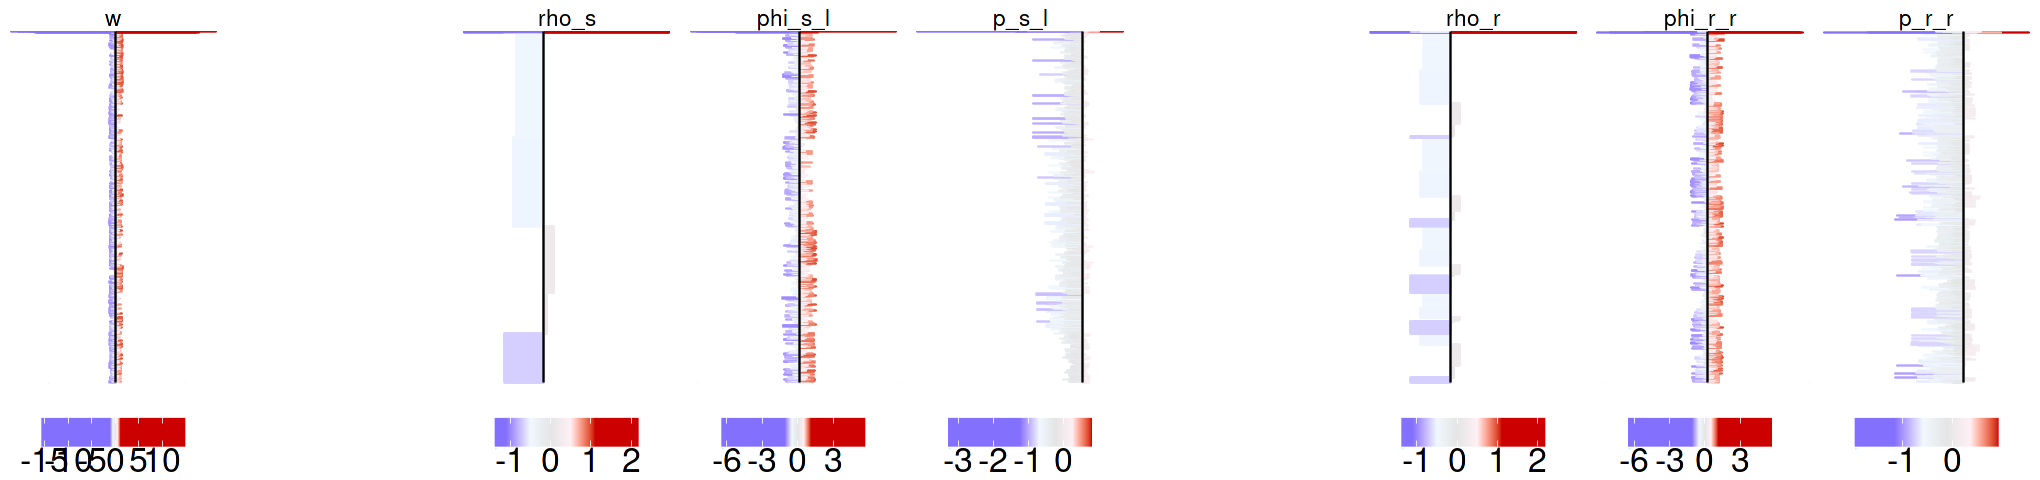

In [29]:
IDs <- as.character(c(ID_order_no_change
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 4)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] Mono:TNF_NK:RIPK1 B:ITGA4_B:CD9     B:HLA-DRA_B:CD9   B:NPTN_NK:NCAM1  
[5] B:CD320_T:JAML    B:RYK_Gran:FZD2  
545 Levels: B:ADAM10_Gran:IL6R < B:AFDN_DC:EPHB6 < ... < T:VEGFB_Mono:NRP1
[1] -11.121820  -3.327943  -3.653799  -1.425524  -1.589608  -1.220128


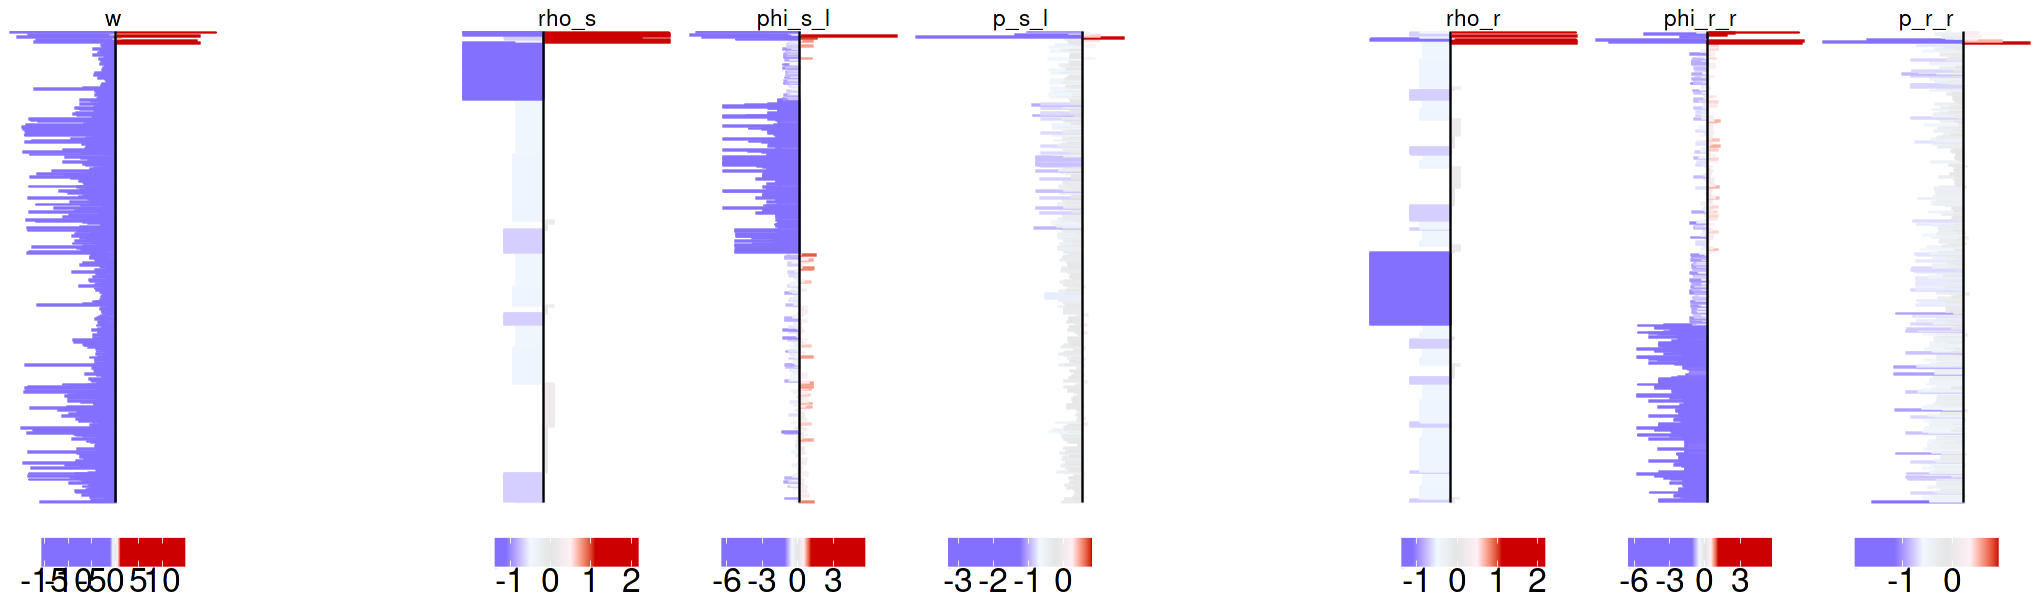

In [30]:
IDs <- as.character(c(ID_order_rho_s_only_down
                         ,ID_order_phi_s_only_down
                         ,ID_order_p_s_only_down
                         ,ID_order_rho_r_only_down
                         ,ID_order_phi_r_only_down
                         ,ID_order_p_r_only_down
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 5#3
       )

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] HSPC:CD79B_Mono:CD244 DC:CALM1_HSPC:PDE1B   HSPC:APP_Gran:FPR2   
[4] Mono:ICAM1_HSPC:ITGAX HSPC:ADAM10_DC:AXL    B:GDF11_HSPC:ACTR2   
15 Levels: B:BMP3_Gran:ACVR1B < B:GDF11_HSPC:ACTR2 < ... < Mono:ICAM1_HSPC:ITGAX
[1]   1.0584318  12.2874760 -12.1147937  11.8764673 -11.7623581  -0.0181508


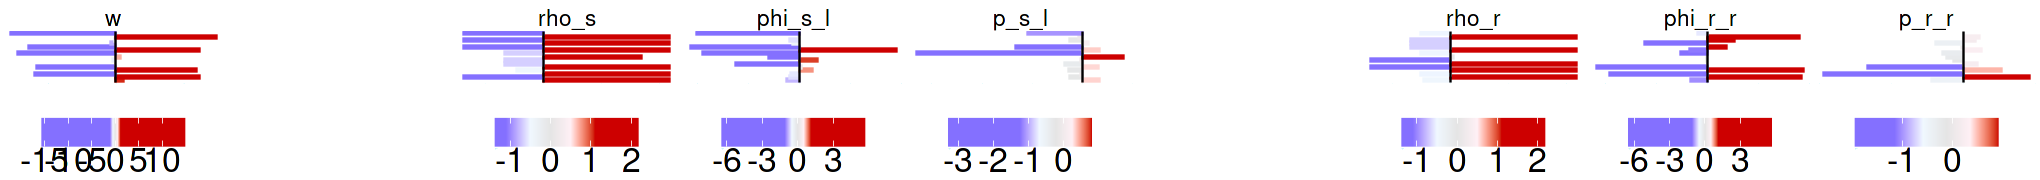

In [31]:
IDs <- as.character(c(ID_order_rho_s_only_up
                          ,ID_order_phi_s_only_up
                          ,ID_order_p_s_only_up
                          ,ID_order_rho_r_only_up
                          ,ID_order_phi_r_only_up
                          ,ID_order_p_r_only_up
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] Gran:SIGLEC9_DC:CD33   DC:IL18_NK:IL18R1      DC:LILRB2_Gran:SIGLEC9
[4] DC:APP_Gran:FPR2       DC:VEGFA_DC:VCAN       DC:PTGS2_DC:ALOX5     
1051 Levels: B:ADAM10_DC:AXL < B:ADAM10_DC:TSPAN33 < ... < T:UBC_DC:RIPK1
[1]  -1.898485  -1.108948  -2.429918 -14.515338  -4.409967  -4.194435


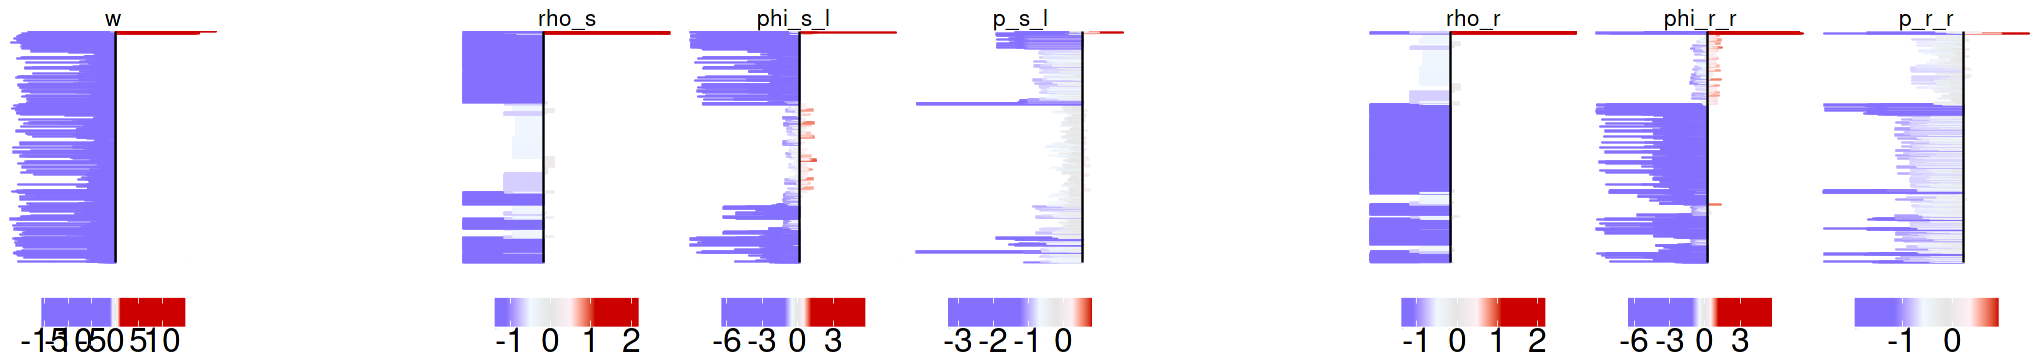

In [32]:
IDs <- as.character(c(ID_order_concordantDown_s
                          ,ID_order_concordantDown_r
                          ,ID_order_concordantDown_b_one_one
                          ,ID_order_concordantDown_b_one_several
                          ,ID_order_concordantDown_b_several_one
                          ,ID_order_concordantDown_b_several_several
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 3)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] HSPC:NRXN2_HSPC:FGFRL1 HSPC:PLAU_HSPC:ITGB2   HSPC:PLAU_HSPC:ITGB1  
[4] HSPC:PLAU_HSPC:ITGAV   HSPC:PLAU_HSPC:ITGA5   HSPC:FGFRL1_HSPC:FGFR1
91 Levels: B:BMP3_Gran:ACVR1B < B:CALM1_HSPC:PDE1B < ... < T:UBC_HSPC:TLR4
[1] 14.68420 13.83344 14.67469 14.30318 14.46983 13.78517


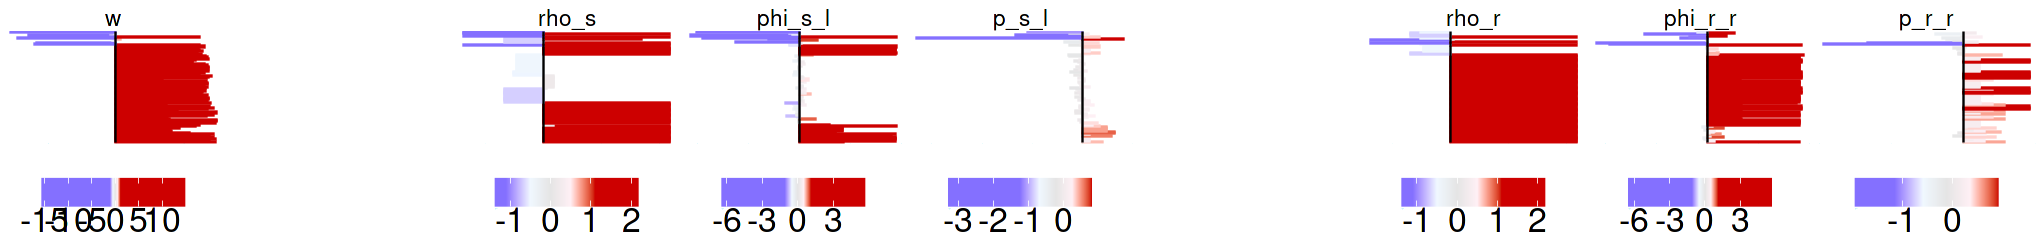

In [33]:
IDs <- as.character(c(ID_order_concordantUp_s
                          ,ID_order_concordantUp_r
                          ,ID_order_concordantUp_b_one_one
                          ,ID_order_concordantUp_b_one_several
                          ,ID_order_concordantUp_b_several_one
                          ,ID_order_concordantUp_b_several_several
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 2)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] Gran:THBS1_B:TGFB1  Gran:CD14_T:PLXND1  Gran:THBS1_T:SLC7A5
[4] Gran:THBS1_T:PTPRJ  Gran:THBS1_T:ITGAV  Mono:IL15RA_T:IL2RB
810 Levels: B:ANXA1_DC:FPR1 < B:APP_Ery:NOTCH2 < ... < T:VCAN_DC:SELL
[1]  -4.255834  -3.861307  -5.248561  -5.117141 -10.670419  -5.162831


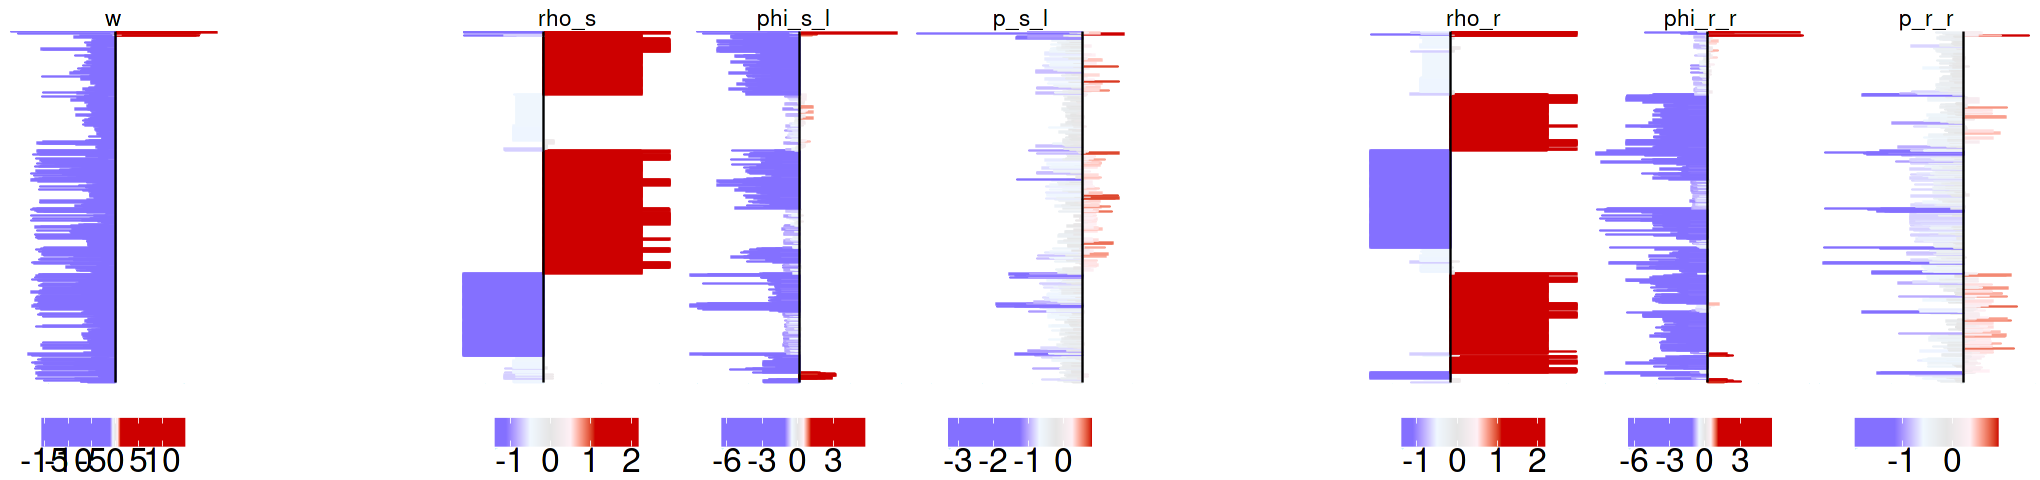

In [34]:
IDs <- as.character(c(ID_order_insuffDown_s
                          ,ID_order_insuffDown_r
                          ,ID_order_insuffDown_b
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 4)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

[1] Gran:F13A1_HSPC:ITGB1 Gran:F13A1_HSPC:ITGA4 DC:CALM1_HSPC:PDE1B  
[4] HSPC:NPTN_NK:NCAM1    HSPC:RYK_Gran:FZD2    HSPC:HMGB1_Gran:CD163
29 Levels: B:BMP3_Gran:ACVR1B < B:GDF11_HSPC:ACTR2 < ... < Mono:ICAM1_HSPC:ITGAX
[1]  1.169803  1.081884 12.287476  1.030857  2.213846  1.255879


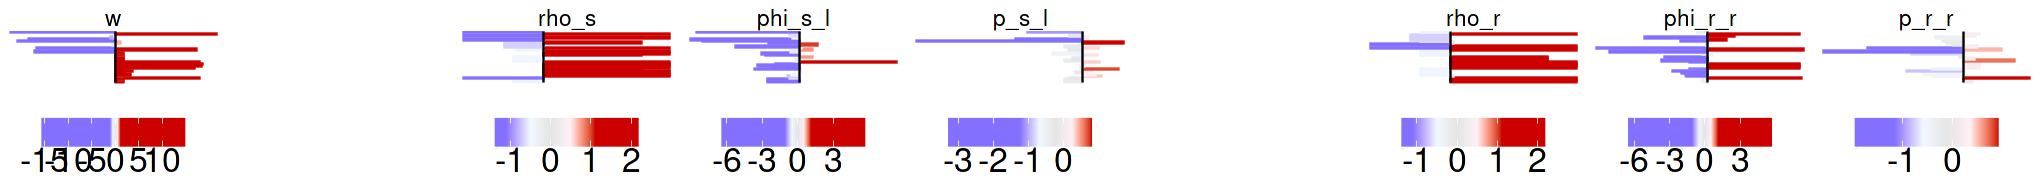

In [35]:
IDs <- as.character(c(ID_order_insuffUp_s
                          ,ID_order_insuffUp_r
                          ,ID_order_insuffUp_b
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

In [36]:
length(ID_order_suffComp_b)

[1] 784

[1] B:TNFRSF17_B:LY9         NK:NCAM1_Mono:FGFR1      Gran:NID1_T:ITGAV       
[4] Gran:HLA-DPB1_T:LAG3     Gran:NECTIN1_Mono:FGFR1  Mono:ENTPD1_Mono:ADORA2A
1721 Levels: B:ACTR2_Ery:LDLR < B:ADAM10_Ery:CD44 < ... < T:VCAN_NK:SELL
[1] -0.1684685  0.1352696 -0.5754491 -0.4338942  0.2308842  0.2532422


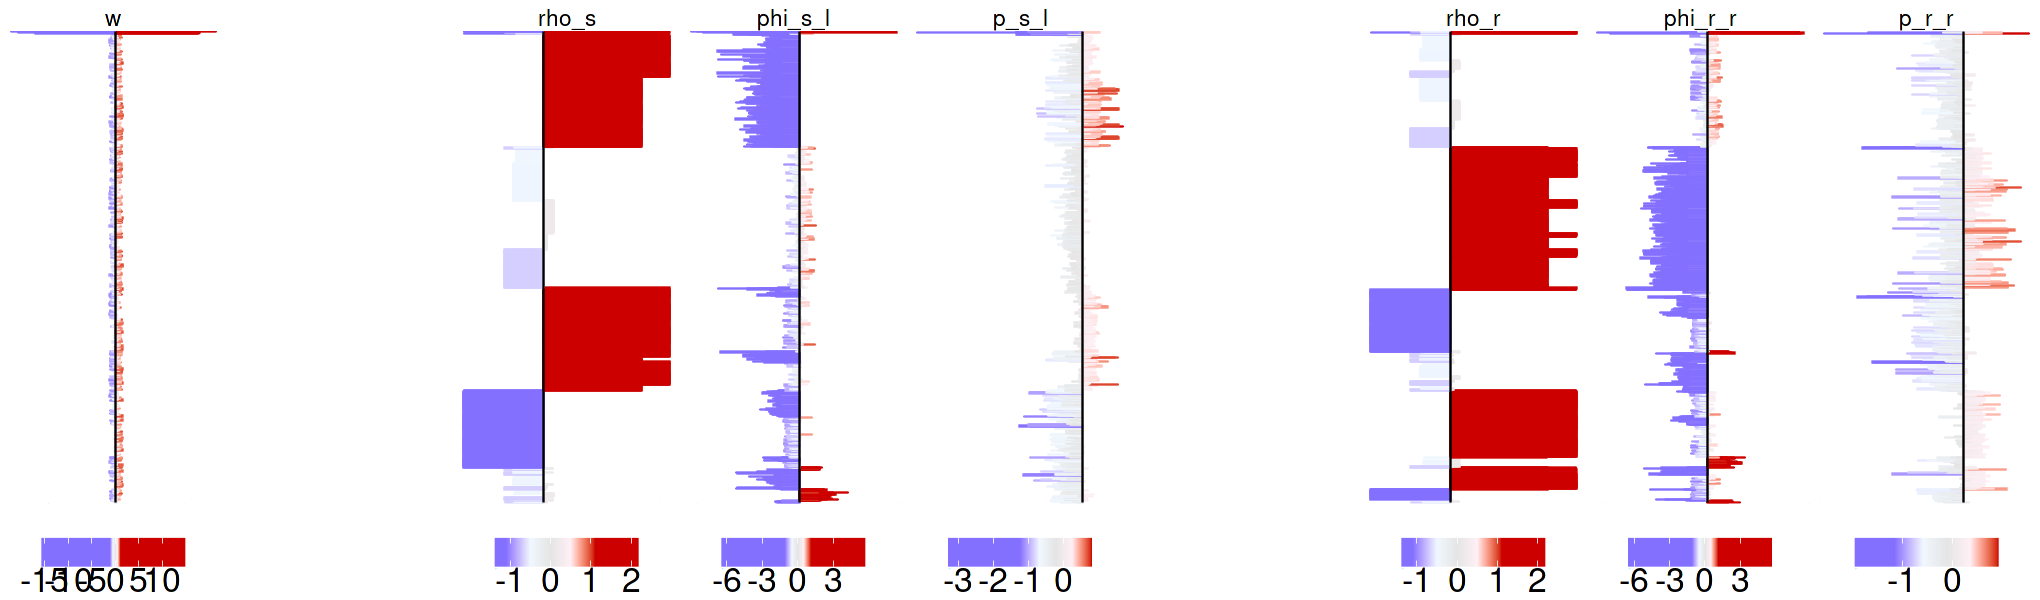

In [37]:
IDs <- as.character(c(ID_order_suffComp_s
                          ,ID_order_suffComp_r
                          ,ID_order_suffComp_b
                     ))
IDs <- c(IDs_lim[!(IDs_lim %in% IDs)]
        ,IDs)

# revert
IDs <- IDs[length(IDs):1]

options(repr.plot.width = 17
       ,repr.plot.height = 5)

rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
my_anno_interactions <- interactions$anno_interactions[IDs,]
my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                             ,ordered = TRUE
                                                    )

print(head(my_anno_interactions$interaction_ID))
print(head(my_anno_interactions$log2FC_weights))


plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                 ,my_anno_interactions = my_anno_interactions
                 ,keep_order = TRUE
                 ,threshold = 1
                 ,legend_title_size = 0
                 ,legend_text_size = 20
                )

In [38]:
idx_sign_lasry <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
sum(idx_sign_lasry)

[1] 2779

In [48]:
interactions$anno_samples

,Sample.ID,sex,Age,Sequencing,sample_ID,Institution,Manuscript.ID,Dx,DxELN_Cytogenetic,Cytogenetics,⋯,ZRSR2,health_status,case_or_control,nr_cells_raw,nr_cells_cf,nr_cells_cf_ctf,total_counts_raw_cf_ctf_gf,nr_celltypes_cf_ctf_gf,threshold_nr_celltypes,passed_threshold_nr_celltypes
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
0,U-06-0024,M,64,CITE-seq,AML-0024,OSU,AML0024,AML,Adverse,"48,XY,+8,+8,i(8)(p10),t(9;15)(q33;q15),del(10)(q22.1q24),del(13)(q14q21)",⋯,0,AML,case,6141,6127,6127,16080180,8,greater or equal 7,True
1,U-16-0160,M,74,CITE-seq,AML-0160,OSU,AML0160,AML,Adverse,"46,XY[30]",⋯,0,AML,case,2186,2169,2149,4764256,7,greater or equal 7,True
2,U-11-0693,F,77,CITE-seq + scTCR-seq,AML-0693,OSU,AML0693,AML,Adverse,"74-89<4n>,XXXX,-8,-9,-9,-12,-17,i(17)(q10),+mar1,+mar2,+dmin[cp18]/46,XX[2] .ish dmin(amp CMYC)",⋯,NA,AML,case,3604,3385,3353,7218310,8,greater or equal 7,True
3,U-18-1371,M,78,CITE-seq,AML-1371,OSU,AML1371,AML,,"46,XY (17 metas), -Y in 3 metas",⋯,0,AML,case,3190,3183,3182,8180661,8,greater or equal 7,True
4,U-16-2123,F,71,CITE-seq,AML-2123,OSU,AML2123,AML,Intermediate,"46,XX",⋯,NA,AML,case,1333,1278,1265,2819870,7,greater or equal 7,True
5,U-16-3133,M,57,CITE-seq,AML-3133,OSU,AML3133,AML,Favorable,"46,XY[19]/nonclonal[1]",⋯,0,AML,case,2499,2457,2448,4903210,8,greater or equal 7,True
6,U-18-4340,M,80,CITE-seq,AML-4340,OSU,AML4340,AML,Intermediate,"46,XY",⋯,0,AML,case,2800,2793,2787,6733115,7,greater or equal 7,True
7,1,F,26,CITE-Seq,healthy-1,,,,,,⋯,NA,healthy,control,2995,2964,2832,6251499,8,greater or equal 7,True
8,2,M,39,CITE-Seq,healthy-2,,,,,,⋯,NA,healthy,control,2489,2476,2399,5431881,8,greater or equal 7,True


In [39]:
# ligands and receptors in the immune interactions: down in Lasry
idx_down_Lasry_immune <- idx_sign_lasry & (
    interactions$anno_interactions$log2FC_weights < 0) & (
    !(grepl("Ery",interactions$anno_interactions$interaction_ID)
     ) & !(grepl("HSPC", interactions$anno_interactions$interaction_ID))
)

In [40]:
ligrec_down_Lasry_immune <- unique(c(interactions$anno_interactions$ligand_gene_name[idx_down_Lasry_immune]
                                               ,interactions$anno_interactions$receptor_gene_name[idx_down_Lasry_immune]
                                              )
                                            )

In [41]:
print(str(ligrec_down_Lasry_immune))
write.csv(ligrec_down_Lasry_immune
         ,file = paste0(path_in,"ligrec_downImmune_Lasry.csv")
         ,row.names=FALSE
         ,quote=FALSE)

 chr [1:489] "ANXA1" "B2M" "CAMP" "CD48" "CD58" "HLA-DOA" "HP" "NRG1" ...
NULL


In [42]:
# ligands and receptors: good quality in Lasry (background set)
idx_good <- interactions$anno_interactions$passed_QC_filter
ligrec_goodQuality_Lasry <- unique(c(interactions$anno_interactions$ligand_gene_name[idx_good]
                                               ,interactions$anno_interactions$receptor_gene_name[idx_good]
                                              )
                                            )


In [43]:
print(str(ligrec_goodQuality_Lasry))
write.csv(ligrec_goodQuality_Lasry 
         ,file = paste0(path_in,"ligrec_goodQuality_Lasry.csv")
         ,row.names=FALSE
         ,quote=FALSE)

 chr [1:776] "ACTR2" "ADM" "ADO" "AFDN" "AGTRAP" "ALCAM" "ANG" "ANXA1" ...
NULL


In [44]:
# random 387 genes
ligrec_random <- ligrec_goodQuality_Lasry[sample.int(660, 387)]
print(length(unique(ligrec_random)))


[1] 387


In [46]:
paste0('For the communication analysis, the threshold_celltype_size and',
  ' the threshold_nr_active_cells were both set to ',interactions$thresholds$threshold_nr_active_cells,
  ' cells, the threshold_expr  was set to ',interactions$thresholds$threshold_expr ,
  ' The total number of interactions were ',nrow(interactions$anno_interactions), 
  '. For the QC, the  threshold_log10_cum_weight, ',
  'the threshold_frac_samples_per_condition, and the threshold_log10meanexpr_per_condition were set to ',
  interactions$thresholds$threshold_log10_cum_weight, ', ',  interactions$thresholds$threshold_frac_samples_per_condition,
  ', ', interactions$thresholds$threshold_log10_meanexpr_per_condition,
  ' respectively. The total number of good quality interactions was ',sum(idx_good),
  '. The differential communication analysis was run on good quality interactions using t-test on log2-',
  'transformed weights and FDR adjustment. The threshold_log2FC was set to ', interactions$thresholds$threshold_log2FC ,
  ' and the threshold_fdr was set to ',interactions$thresholds$threshold_fdr ,
  ', which yielded ',sum(idx_down & idx_sign),' downregulated and ',sum(idx_up & idx_sign) ,' upregulated interactions.')

[1] "For the communication analysis, the threshold_celltype_size and the threshold_nr_active_cells were both set to 6 cells, the threshold_expr  was set to 0.1 The total number of interactions were 151744. For the QC, the  threshold_log10_cum_weight, the threshold_frac_samples_per_condition, and the threshold_log10meanexpr_per_condition were set to 0.01, 0.6, 0.02 respectively. The total number of good quality interactions was 23128. The differential communication analysis was run on good quality interactions using t-test on log2-transformed weights and FDR adjustment. The threshold_log2FC was set to 1 and the threshold_fdr was set to 0.1, which yielded 2670 downregulated and 109 upregulated interactions."

In [47]:
sum(idx_down & idx_sign,idx_up & idx_sign)

[1] 2779

In [47]:
write.csv(ligrec_random
         ,file = "ligrec_random_Lasry.csv"
         ,row.names=FALSE
         ,quote=FALSE)

In [100]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridExtra_2.3         igraph_1.4.2          circlize_0.4.15      
[4] ComplexHeatmap_2.10.0 ggrepel_0.9.2         ggplot2_3.4.2        
[7] community_1.3.8      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-7    